In [8]:
!pip install wandb

In [5]:
import os
import numpy as np
import zipfile
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim
from pathlib import Path
import json
import wandb

In [6]:
dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
dataset_zip_path = "/kaggle/working/nature_12K.zip"
dataset_dir = "nature_12K"

In [7]:
if not os.path.exists(dataset_dir):
    if not os.path.exists(dataset_zip_path):
        print("Downloading iNaturalist-12K...")
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(dataset_zip_path, 'wb') as f, tqdm(
            desc=dataset_zip_path,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)

/kaggle/working/nature_12K.zip: 100%|██████████| 3.55G/3.55G [02:00<00:00, 31.6MiB/s] 


In [8]:
if not os.path.exists(dataset_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

Extracting dataset...


In [16]:
def prepare_datasets(data_dir, val_split=0.2, batch_size=32, image_size=(224, 224)):
    data_dir = Path(data_dir)

    # Define transforms (customize as needed)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Converts to [0, 1] and CxHxW
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize RGB
    ])

    # Load training and testing datasets
    full_train_dataset = ImageFolder(root=data_dir / "train", transform=transform)
    test_dataset = ImageFolder(root=data_dir / "val", transform=transform)

    # Create validation split from training set
    val_size = int(val_split * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Extract X and Y by iterating over DataLoader batches if needed
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Convert to X, Y tensors
    def extract_XY(loader):
        for X, Y in loader:
            return X, Y

    X_train, Y_train = extract_XY(train_loader)
    X_val, Y_val = extract_XY(val_loader)
    X_test, Y_test = extract_XY(test_loader)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [17]:
# dataset_dir = "/kaggle/working/inaturalist_12K"

In [ ]:
# X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare_datasets(
#     data_dir='/kaggle/working/inaturalist_12K', val_split=0.2, batch_size=64, image_size=(224, 224)
# )

In [ ]:
# print(X_train.shape)

# Part A
### Question 1

Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer.

After 5 such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing 10 neurons. The input layer should be compatible with the images in the iNaturalist dataset dataset.
The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.

In [15]:
api_key = "7040d84a3ed65a967eb3389dd6fe774b418576ed" 
wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
class FlexibleCNN(nn.Module):
    def __init__(self, 
                 num_filters=32,  # number of filters in each conv layer
                 filter_size=3,   # size of filters (k x k)
                 activation='relu',  # activation function
                 dense_neurons=512,  # number of neurons in dense layer
                 input_channels=3,   # RGB images
                 num_classes=10,    # number of output classes
                 use_batch_norm=True,  # whether to use batch normalization
                 dropout_rate=0.2):  # dropout rate
        super(FlexibleCNN, self).__init__()
        
        # Store parameters for calculations
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dense_neurons = dense_neurons
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        
        # Choose activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'silu':
            self.activation = nn.SiLU()
        elif activation.lower() == 'mish':
            self.activation = nn.Mish()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Create 5 conv-activation-maxpool blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels
        
        for _ in range(5):
            block = []
            # Conv layer
            block.append(nn.Conv2d(in_channels, num_filters, filter_size, padding=filter_size//2))
            
            # Batch normalization if enabled
            if use_batch_norm:
                block.append(nn.BatchNorm2d(num_filters))
            
            # Activation
            block.append(self.activation)
            
            # Max pooling
            block.append(nn.MaxPool2d(2, 2))
            
            # Dropout after pooling
            block.append(nn.Dropout2d(dropout_rate))
            
            self.conv_blocks.extend(block)
            in_channels = num_filters
        
        # Calculate the size of the flattened features after conv blocks
        # Assuming input size of 224x224 (standard for iNaturalist)
        self.flattened_size = num_filters * (224 // (2**5)) * (224 // (2**5))
        
        # Dense layers
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, dense_neurons),
            self.activation,
            nn.Dropout(dropout_rate),  # Dropout before final layer
            nn.Linear(dense_neurons, num_classes)
        )
    
    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x
    
    def get_computations(self):
        """Calculate total number of computations"""
        # Computations in conv layers
        conv_computations = 0
        input_size = 224
        in_channels = 3
        
        for i in range(5):
            # Each conv layer
            conv_computations += (input_size * input_size * in_channels * 
                                self.num_filters * self.filter_size * self.filter_size)
            # Each maxpool reduces size by 2
            input_size = input_size // 2
            in_channels = self.num_filters
        
        # Computations in dense layers
        dense_computations = (self.flattened_size * self.dense_neurons +  # first dense layer
                            self.dense_neurons * 10)  # output layer
        
        return conv_computations + dense_computations
    
    def get_parameters(self):
        """Calculate total number of parameters"""
        # Parameters in conv layers
        conv_params = 0
        in_channels = 3
        
        for _ in range(5):
            # Each conv layer has (filter_size * filter_size * in_channels + 1) * num_filters parameters
            conv_params += (self.filter_size * self.filter_size * in_channels + 1) * self.num_filters
            # Batch norm parameters if enabled
            if self.use_batch_norm:
                conv_params += 2 * self.num_filters  # gamma and beta for each channel
            in_channels = self.num_filters
        
        # Parameters in dense layers
        dense_params = (self.flattened_size * self.dense_neurons + self.dense_neurons +  # first dense layer
                       self.dense_neurons * 10 + 10)  # output layer
        
        return conv_params + dense_params

In [13]:
def train(config=None):
    # Initialize wandb
    with wandb.init(config=config):
        config = wandb.config
        
        # Set random seed for reproducibility
        torch.manual_seed(config.seed)
        np.random.seed(config.seed)
        
        # Data augmentation and normalization
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Load dataset
        train_dataset = datasets.ImageFolder(
            root='/kaggle/working/inaturalist_12K/train',
            transform=train_transform
        )
        
        # Split into train and validation
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use stratified split to maintain class balance
        train_indices, val_indices = train_test_split(
            list(range(len(train_dataset))),
            test_size=0.2,
            stratify=train_dataset.targets,
            random_state=config.seed
        )
        
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)
        
        train_loader = DataLoader(
            train_subset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=4
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=4
        )
        
        # Initialize model
        model = FlexibleCNN(
            num_filters=config.num_filters,
            filter_size=config.filter_size,
            activation=config.activation,
            dense_neurons=config.dense_neurons,
            use_batch_norm=config.use_batch_norm,
            dropout_rate=config.dropout_rate
        )
        
        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        # Format the run name
        run_name = f"nf_{config.num_filters}_fs_{config.filter_size}_act_{config.activation}_dn_{config.dense_neurons}_lr_{config.learning_rate}_bs_{config.batch_size}_bn_{config.use_batch_norm}_dr_{config.dropout_rate}"

        # Set the run name
        wandb.run.name = run_name
        
        # Training loop
        best_val_acc = 0
        best_config = None
        
        for epoch in range(config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            
            train_acc = 100. * train_correct / train_total
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()
            
            val_acc = 100. * val_correct / val_total
            
            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss / len(train_loader),
                "train_acc": train_acc,
                "val_loss": val_loss / len(val_loader),
                "val_acc": val_acc
            })
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')
                best_config = dict(config)
                with open('best_config.json', 'w') as f:
                    json.dump(best_config, f, indent=4)
            
            print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Acc: {val_acc:.2f}%')
            

In [17]:

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
            'values': [16, 32, 64]
        },
        'filter_size': {
            'values': [3]
        },
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'dense_neurons': {
            'values': [128, 256]
        },
        'learning_rate': {
            'min': 1e-4,
            'max': 1e-2
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'use_batch_norm': {
            'values': [True, False]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4]
        },
        'epochs': {
            'value': 5
        },
        'seed': {
            'value': 42
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="inaturalist-cnn-sweep_01")

# Run sweep
wandb.agent(sweep_id, train, count=20)

Create sweep with ID: 9efa88ed
Sweep URL: https://wandb.ai/da24m004-iitmaana/inaturalist-cnn-sweep_01/sweeps/9efa88ed


wandb: Agent Starting Run: wke1qxpx with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.006689131780273198
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: True
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch: 0, Batch: 0, Loss: 2.2622
Epoch: 0, Batch: 100, Loss: 2.3305
Epoch: 0, Train Loss: 2.3649, Train Acc: 11.36%, Val Loss: 2.2542, Val Acc: 14.20%
Epoch: 1, Batch: 0, Loss: 2.2668
Epoch: 1, Batch: 100, Loss: 2.2545
Epoch: 1, Train Loss: 2.2989, Train Acc: 12.21%, Val Loss: 2.2655, Val Acc: 14.25%
Epoch: 2, Batch: 0, Loss: 2.3015
Epoch: 2, Batch: 100, Loss: 2.2717
Epoch: 2, Train Loss: 2.2829, Train Acc: 13.43%, Val Loss: 2.2421, Val Acc: 15.00%
Epoch: 3, Batch: 0, Loss: 2.3128
Epoch: 3, Batch: 100, Loss: 2.3542
Epoch: 3, Train Loss: 2.2862, Train Acc: 13.40%, Val Loss: 2.2455, Val Acc: 16.50%
Epoch: 4, Batch: 0, Loss: 2.2717
Epoch: 4, Batch: 100, Loss: 2.2107
Epoch: 4, Train Loss: 2.3018, Train Acc: 12.73%, Val Loss: 2.2561, Val Acc: 14.40%


wandb: Agent Starting Run: qkx2ymj2 with config:
wandb: 	activation: gelu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00849705605694353
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3082
Epoch: 0, Train Loss: 2.5841, Train Acc: 10.19%, Val Loss: 2.3047, Val Acc: 9.55%
Epoch: 1, Batch: 0, Loss: 2.2968
Epoch: 1, Train Loss: 2.3081, Train Acc: 9.54%, Val Loss: 2.3015, Val Acc: 10.20%
Epoch: 2, Batch: 0, Loss: 2.3053
Epoch: 2, Train Loss: 2.3018, Train Acc: 9.98%, Val Loss: 2.3048, Val Acc: 10.95%
Epoch: 3, Batch: 0, Loss: 2.3342
Epoch: 3, Train Loss: 2.3050, Train Acc: 9.39%, Val Loss: 2.3027, Val Acc: 12.45%
Epoch: 4, Batch: 0, Loss: 2.3027
Epoch: 4, Train Loss: 2.3032, Train Acc: 9.45%, Val Loss: 2.3027, Val Acc: 9.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5zvbrexa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0032079120779124532
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3055
Epoch: 0, Batch: 100, Loss: 2.2547
Epoch: 0, Batch: 200, Loss: 2.3102
Epoch: 0, Train Loss: 2.3085, Train Acc: 9.99%, Val Loss: 2.3030, Val Acc: 10.00%
Epoch: 1, Batch: 0, Loss: 2.3014
Epoch: 1, Batch: 100, Loss: 2.3066
Epoch: 1, Batch: 200, Loss: 2.3012
Epoch: 1, Train Loss: 2.3050, Train Acc: 9.68%, Val Loss: 2.3027, Val Acc: 10.00%
Epoch: 2, Batch: 0, Loss: 2.3021
Epoch: 2, Batch: 100, Loss: 2.2995
Epoch: 2, Batch: 200, Loss: 2.3091
Epoch: 2, Train Loss: 2.3035, Train Acc: 9.74%, Val Loss: 2.3027, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.3046
Epoch: 3, Batch: 100, Loss: 2.2955
Epoch: 3, Batch: 200, Loss: 2.2985
Epoch: 3, Train Loss: 2.3033, Train Acc: 9.54%, Val Loss: 2.3027, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3031
Epoch: 4, Batch: 100, Loss: 2.3056
Epoch: 4, Batch: 200, Loss: 2.3048
Epoch: 4, Train Loss: 2.3033, Train Acc: 9.83%, Val Loss: 2.3027, Val Acc: 10.00%


wandb: Agent Starting Run: wqdivcwx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.002560952549606059
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3655
Epoch: 0, Batch: 100, Loss: 2.2735
Epoch: 0, Batch: 200, Loss: 2.2584
Epoch: 0, Train Loss: 2.3081, Train Acc: 11.94%, Val Loss: 2.2562, Val Acc: 16.60%
Epoch: 1, Batch: 0, Loss: 2.2485
Epoch: 1, Batch: 100, Loss: 2.2847
Epoch: 1, Batch: 200, Loss: 2.3977
Epoch: 1, Train Loss: 2.2687, Train Acc: 13.93%, Val Loss: 2.2244, Val Acc: 16.90%
Epoch: 2, Batch: 0, Loss: 2.2335
Epoch: 2, Batch: 100, Loss: 2.1540
Epoch: 2, Batch: 200, Loss: 2.2255
Epoch: 2, Train Loss: 2.2500, Train Acc: 15.55%, Val Loss: 2.1808, Val Acc: 20.45%
Epoch: 3, Batch: 0, Loss: 2.2565
Epoch: 3, Batch: 100, Loss: 2.2203
Epoch: 3, Batch: 200, Loss: 2.2146
Epoch: 3, Train Loss: 2.2378, Train Acc: 16.04%, Val Loss: 2.1849, Val Acc: 19.00%
Epoch: 4, Batch: 0, Loss: 2.3412
Epoch: 4, Batch: 100, Loss: 2.2780
Epoch: 4, Batch: 200, Loss: 2.2309
Epoch: 4, Train Loss: 2.2240, Train Acc: 17.05%, Val Loss: 2.1618, Val Acc: 21.15%


wandb: Agent Starting Run: tstjys4z with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00011743350251220296
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3553
Epoch: 0, Train Loss: 2.3220, Train Acc: 11.23%, Val Loss: 2.2871, Val Acc: 13.20%
Epoch: 1, Batch: 0, Loss: 2.3027
Epoch: 1, Train Loss: 2.2774, Train Acc: 14.24%, Val Loss: 2.2810, Val Acc: 15.35%
Epoch: 2, Batch: 0, Loss: 2.2501
Epoch: 2, Train Loss: 2.2571, Train Acc: 16.55%, Val Loss: 2.2585, Val Acc: 13.85%
Epoch: 3, Batch: 0, Loss: 2.2204
Epoch: 3, Train Loss: 2.2295, Train Acc: 17.34%, Val Loss: 2.2372, Val Acc: 16.40%
Epoch: 4, Batch: 0, Loss: 2.1985
Epoch: 4, Train Loss: 2.2071, Train Acc: 18.49%, Val Loss: 2.2044, Val Acc: 20.60%


wandb: Agent Starting Run: 7qqwbwrj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0049711719217265145
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3655
Epoch: 0, Batch: 100, Loss: 2.2949
Epoch: 0, Batch: 200, Loss: 2.2702
Epoch: 0, Train Loss: 2.3222, Train Acc: 11.23%, Val Loss: 2.2983, Val Acc: 10.20%
Epoch: 1, Batch: 0, Loss: 2.3391
Epoch: 1, Batch: 100, Loss: 2.2824
Epoch: 1, Batch: 200, Loss: 2.2578
Epoch: 1, Train Loss: 2.2927, Train Acc: 11.44%, Val Loss: 2.2739, Val Acc: 14.00%
Epoch: 2, Batch: 0, Loss: 2.2984
Epoch: 2, Batch: 100, Loss: 2.2752
Epoch: 2, Batch: 200, Loss: 2.2828
Epoch: 2, Train Loss: 2.2829, Train Acc: 12.03%, Val Loss: 2.2554, Val Acc: 15.75%
Epoch: 3, Batch: 0, Loss: 2.2905
Epoch: 3, Batch: 100, Loss: 2.2917
Epoch: 3, Batch: 200, Loss: 2.2703
Epoch: 3, Train Loss: 2.2837, Train Acc: 11.85%, Val Loss: 2.2715, Val Acc: 11.75%
Epoch: 4, Batch: 0, Loss: 2.2583
Epoch: 4, Batch: 100, Loss: 2.2921
Epoch: 4, Batch: 200, Loss: 2.3306
Epoch: 4, Train Loss: 2.2810, Train Acc: 12.41%, Val Loss: 2.2630, Val Acc: 14.25%


wandb: Agent Starting Run: n8rtzu4k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.007305495531135846
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3592
Epoch: 0, Train Loss: 2.4848, Train Acc: 10.25%, Val Loss: 2.3012, Val Acc: 10.60%
Epoch: 1, Batch: 0, Loss: 2.3005
Epoch: 1, Train Loss: 2.3095, Train Acc: 10.33%, Val Loss: 2.2941, Val Acc: 11.80%
Epoch: 2, Batch: 0, Loss: 2.3009
Epoch: 2, Train Loss: 2.2980, Train Acc: 10.85%, Val Loss: 2.2816, Val Acc: 12.90%
Epoch: 3, Batch: 0, Loss: 2.2978
Epoch: 3, Train Loss: 2.2924, Train Acc: 11.88%, Val Loss: 2.2718, Val Acc: 14.80%
Epoch: 4, Batch: 0, Loss: 2.2983
Epoch: 4, Train Loss: 2.2916, Train Acc: 11.09%, Val Loss: 2.2741, Val Acc: 14.20%


wandb: Agent Starting Run: oxxzca9b with config:
wandb: 	activation: silu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00543724762469224
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2536
Epoch: 0, Batch: 100, Loss: 2.3674
Epoch: 0, Batch: 200, Loss: 2.2867
Epoch: 0, Train Loss: 2.3604, Train Acc: 12.71%, Val Loss: 2.2427, Val Acc: 14.90%
Epoch: 1, Batch: 0, Loss: 2.2157
Epoch: 1, Batch: 100, Loss: 2.1997
Epoch: 1, Batch: 200, Loss: 2.2709
Epoch: 1, Train Loss: 2.2770, Train Acc: 15.39%, Val Loss: 2.2067, Val Acc: 19.40%
Epoch: 2, Batch: 0, Loss: 2.1449
Epoch: 2, Batch: 100, Loss: 2.2887
Epoch: 2, Batch: 200, Loss: 2.2811
Epoch: 2, Train Loss: 2.2537, Train Acc: 16.08%, Val Loss: 2.1941, Val Acc: 19.25%
Epoch: 3, Batch: 0, Loss: 2.2042
Epoch: 3, Batch: 100, Loss: 2.2080
Epoch: 3, Batch: 200, Loss: 2.2661
Epoch: 3, Train Loss: 2.2569, Train Acc: 16.71%, Val Loss: 2.1744, Val Acc: 21.45%
Epoch: 4, Batch: 0, Loss: 2.0980
Epoch: 4, Batch: 100, Loss: 2.2733
Epoch: 4, Batch: 200, Loss: 2.1487
Epoch: 4, Train Loss: 2.2259, Train Acc: 17.81%, Val Loss: 2.1842, Val Acc: 20.70%


wandb: Agent Starting Run: 0kxgg3co with config:
wandb: 	activation: mish
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00526935375028115
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3007
Epoch: 0, Batch: 100, Loss: 2.2507
Epoch: 0, Train Loss: 2.3138, Train Acc: 11.31%, Val Loss: 2.2510, Val Acc: 17.10%
Epoch: 1, Batch: 0, Loss: 2.2521
Epoch: 1, Batch: 100, Loss: 2.3546
Epoch: 1, Train Loss: 2.3117, Train Acc: 12.25%, Val Loss: 2.2803, Val Acc: 15.15%
Epoch: 2, Batch: 0, Loss: 2.3196
Epoch: 2, Batch: 100, Loss: 2.3351
Epoch: 2, Train Loss: 2.3372, Train Acc: 10.68%, Val Loss: 2.3125, Val Acc: 9.30%
Epoch: 3, Batch: 0, Loss: 2.3582
Epoch: 3, Batch: 100, Loss: 2.3123
Epoch: 3, Train Loss: 2.3256, Train Acc: 10.11%, Val Loss: 2.3036, Val Acc: 9.95%
Epoch: 4, Batch: 0, Loss: 2.2863
Epoch: 4, Batch: 100, Loss: 2.3018
Epoch: 4, Train Loss: 2.3147, Train Acc: 9.91%, Val Loss: 2.3027, Val Acc: 10.00%


wandb: Agent Starting Run: k4rq4wa5 with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0016139221428595938
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3385
Epoch: 0, Train Loss: 2.2218, Train Acc: 19.15%, Val Loss: 2.0621, Val Acc: 25.45%
Epoch: 1, Batch: 0, Loss: 2.1232
Epoch: 1, Train Loss: 2.0969, Train Acc: 23.49%, Val Loss: 2.0127, Val Acc: 27.35%
Epoch: 2, Batch: 0, Loss: 2.0588
Epoch: 2, Train Loss: 2.0664, Train Acc: 25.08%, Val Loss: 1.9889, Val Acc: 28.65%
Epoch: 3, Batch: 0, Loss: 2.0988
Epoch: 3, Train Loss: 2.0325, Train Acc: 27.29%, Val Loss: 1.9628, Val Acc: 31.35%
Epoch: 4, Batch: 0, Loss: 1.8973
Epoch: 4, Train Loss: 2.0234, Train Acc: 27.40%, Val Loss: 1.9439, Val Acc: 31.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mciqvazx with config:
wandb: 	activation: silu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.004372569332862657
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3041
Epoch: 0, Train Loss: 2.5533, Train Acc: 11.98%, Val Loss: 2.2723, Val Acc: 13.75%
Epoch: 1, Batch: 0, Loss: 2.3157
Epoch: 1, Train Loss: 2.2662, Train Acc: 13.96%, Val Loss: 2.1858, Val Acc: 16.40%
Epoch: 2, Batch: 0, Loss: 2.2818
Epoch: 2, Train Loss: 2.2563, Train Acc: 16.91%, Val Loss: 2.2868, Val Acc: 12.50%
Epoch: 3, Batch: 0, Loss: 2.2693
Epoch: 3, Train Loss: 2.3409, Train Acc: 10.29%, Val Loss: 2.3031, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.9412
Epoch: 4, Train Loss: 2.3255, Train Acc: 10.03%, Val Loss: 2.3026, Val Acc: 10.00%


wandb: Agent Starting Run: 3hdzk1ts with config:
wandb: 	activation: silu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00914545154496335
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2756
Epoch: 0, Batch: 100, Loss: 2.4729
Epoch: 0, Batch: 200, Loss: 2.4496
Epoch: 0, Train Loss: 2.3837, Train Acc: 12.93%, Val Loss: 2.2587, Val Acc: 13.80%
Epoch: 1, Batch: 0, Loss: 2.2963
Epoch: 1, Batch: 100, Loss: 2.2639
Epoch: 1, Batch: 200, Loss: 2.2873
Epoch: 1, Train Loss: 2.2805, Train Acc: 15.56%, Val Loss: 2.2490, Val Acc: 16.05%
Epoch: 2, Batch: 0, Loss: 2.1587
Epoch: 2, Batch: 100, Loss: 2.2306
Epoch: 2, Batch: 200, Loss: 2.4708
Epoch: 2, Train Loss: 2.2563, Train Acc: 15.30%, Val Loss: 2.2186, Val Acc: 18.70%
Epoch: 3, Batch: 0, Loss: 2.2818
Epoch: 3, Batch: 100, Loss: 2.1887
Epoch: 3, Batch: 200, Loss: 2.1723
Epoch: 3, Train Loss: 2.2540, Train Acc: 16.13%, Val Loss: 2.2253, Val Acc: 18.55%
Epoch: 4, Batch: 0, Loss: 2.0876
Epoch: 4, Batch: 100, Loss: 2.2514
Epoch: 4, Batch: 200, Loss: 2.1759
Epoch: 4, Train Loss: 2.2357, Train Acc: 16.95%, Val Loss: 2.1881, Val Acc: 19.65%


wandb: Agent Starting Run: mouu9u63 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.008637019167515166
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2792
Epoch: 0, Train Loss: 2.4398, Train Acc: 10.33%, Val Loss: 2.3025, Val Acc: 10.35%
Epoch: 1, Batch: 0, Loss: 2.3054
Epoch: 1, Train Loss: 2.3022, Train Acc: 10.58%, Val Loss: 2.3002, Val Acc: 12.35%
Epoch: 2, Batch: 0, Loss: 2.3194
Epoch: 2, Train Loss: 2.3003, Train Acc: 11.39%, Val Loss: 2.2933, Val Acc: 13.05%
Epoch: 3, Batch: 0, Loss: 2.2989
Epoch: 3, Train Loss: 2.2944, Train Acc: 11.23%, Val Loss: 2.2802, Val Acc: 13.30%
Epoch: 4, Batch: 0, Loss: 2.2872
Epoch: 4, Train Loss: 2.2906, Train Acc: 11.69%, Val Loss: 2.2526, Val Acc: 17.25%


wandb: Agent Starting Run: ag58y7tv with config:
wandb: 	activation: mish
wandb: 	batch_size: 32
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.009007026241491394
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3080
Epoch: 0, Batch: 100, Loss: 2.3015
Epoch: 0, Batch: 200, Loss: 2.2885
Epoch: 0, Train Loss: 2.9813, Train Acc: 9.99%, Val Loss: 2.3034, Val Acc: 10.00%
Epoch: 1, Batch: 0, Loss: 2.9593
Epoch: 1, Batch: 100, Loss: 2.3088
Epoch: 1, Batch: 200, Loss: 2.3028
Epoch: 1, Train Loss: 6.8436, Train Acc: 9.68%, Val Loss: 2.3032, Val Acc: 10.00%
Epoch: 2, Batch: 0, Loss: 2.3198
Epoch: 2, Batch: 100, Loss: 2.3004
Epoch: 2, Batch: 200, Loss: 2.2979
Epoch: 2, Train Loss: 7.4924, Train Acc: 9.50%, Val Loss: 2.3031, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.3147
Epoch: 3, Batch: 100, Loss: 2.2983
Epoch: 3, Batch: 200, Loss: 2.3070
Epoch: 3, Train Loss: 4.8987, Train Acc: 9.20%, Val Loss: 2.3033, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3072
Epoch: 4, Batch: 100, Loss: 2.3040
Epoch: 4, Batch: 200, Loss: 2.2971
Epoch: 4, Train Loss: 74.7906, Train Acc: 9.58%, Val Loss: 2.3029, Val Acc: 10.00%


wandb: Agent Starting Run: vxq9l7go with config:
wandb: 	activation: silu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00431105657364926
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3027
Epoch: 0, Train Loss: 2.2992, Train Acc: 14.33%, Val Loss: 2.2847, Val Acc: 12.60%
Epoch: 1, Batch: 0, Loss: 2.3383
Epoch: 1, Train Loss: 2.3264, Train Acc: 10.51%, Val Loss: 2.3028, Val Acc: 10.00%
Epoch: 2, Batch: 0, Loss: 2.2920
Epoch: 2, Train Loss: 2.3051, Train Acc: 9.38%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.3025
Epoch: 3, Train Loss: 2.3031, Train Acc: 9.25%, Val Loss: 2.3026, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3025
Epoch: 4, Train Loss: 2.3029, Train Acc: 9.13%, Val Loss: 2.3026, Val Acc: 10.00%


wandb: Agent Starting Run: 7h6cr5j7 with config:
wandb: 	activation: mish
wandb: 	batch_size: 128
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.00327223860843763
wandb: 	num_filters: 32
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.3073
Epoch: 0, Train Loss: 2.2722, Train Acc: 14.56%, Val Loss: 2.1638, Val Acc: 22.40%
Epoch: 1, Batch: 0, Loss: 2.1902
Epoch: 1, Train Loss: 2.2428, Train Acc: 17.36%, Val Loss: 2.1258, Val Acc: 23.90%
Epoch: 2, Batch: 0, Loss: 2.2253
Epoch: 2, Train Loss: 2.2235, Train Acc: 18.10%, Val Loss: 2.1451, Val Acc: 22.00%
Epoch: 3, Batch: 0, Loss: 2.1706
Epoch: 3, Train Loss: 2.2299, Train Acc: 17.94%, Val Loss: 2.1153, Val Acc: 21.95%
Epoch: 4, Batch: 0, Loss: 2.1101
Epoch: 4, Train Loss: 2.2110, Train Acc: 19.28%, Val Loss: 2.0848, Val Acc: 25.80%


wandb: Agent Starting Run: x54juzv8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0013181681924383174
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.3606
Epoch: 0, Train Loss: 2.2637, Train Acc: 18.10%, Val Loss: 2.1251, Val Acc: 21.75%
Epoch: 1, Batch: 0, Loss: 2.2228
Epoch: 1, Train Loss: 2.1202, Train Acc: 23.39%, Val Loss: 2.0426, Val Acc: 27.60%
Epoch: 2, Batch: 0, Loss: 2.2006
Epoch: 2, Train Loss: 2.0854, Train Acc: 24.70%, Val Loss: 1.9784, Val Acc: 29.05%
Epoch: 3, Batch: 0, Loss: 2.0090
Epoch: 3, Train Loss: 2.0437, Train Acc: 26.34%, Val Loss: 1.9629, Val Acc: 31.10%
Epoch: 4, Batch: 0, Loss: 2.0394
Epoch: 4, Train Loss: 2.0237, Train Acc: 27.82%, Val Loss: 1.9370, Val Acc: 31.75%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkkn8upe with config:
wandb: 	activation: silu
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.003553684272231988
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: False


Epoch: 0, Batch: 0, Loss: 2.2970
Epoch: 0, Batch: 100, Loss: 2.3059
Epoch: 0, Batch: 200, Loss: 2.2503
Epoch: 0, Train Loss: 2.3118, Train Acc: 11.75%, Val Loss: 2.2551, Val Acc: 15.20%
Epoch: 1, Batch: 0, Loss: 2.2232
Epoch: 1, Batch: 100, Loss: 2.3393
Epoch: 1, Batch: 200, Loss: 2.2454
Epoch: 1, Train Loss: 2.3111, Train Acc: 12.85%, Val Loss: 2.2343, Val Acc: 19.40%
Epoch: 2, Batch: 0, Loss: 2.2039
Epoch: 2, Batch: 100, Loss: 2.2902
Epoch: 2, Batch: 200, Loss: 2.3460
Epoch: 2, Train Loss: 2.2924, Train Acc: 13.91%, Val Loss: 2.2462, Val Acc: 15.75%
Epoch: 3, Batch: 0, Loss: 2.1856
Epoch: 3, Batch: 100, Loss: 2.1804
Epoch: 3, Batch: 200, Loss: 2.1860
Epoch: 3, Train Loss: 2.2924, Train Acc: 13.64%, Val Loss: 2.2493, Val Acc: 13.60%
Epoch: 4, Batch: 0, Loss: 2.3781
Epoch: 4, Batch: 100, Loss: 2.3428
Epoch: 4, Batch: 200, Loss: 2.3067
Epoch: 4, Train Loss: 2.2691, Train Acc: 15.91%, Val Loss: 2.1932, Val Acc: 20.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f7lsz62y with config:
wandb: 	activation: mish
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0049975958449634955
wandb: 	num_filters: 64
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2847
Epoch: 0, Batch: 100, Loss: 2.3576
Epoch: 0, Batch: 200, Loss: 2.3249
Epoch: 0, Train Loss: 2.4477, Train Acc: 10.20%, Val Loss: 2.3036, Val Acc: 10.00%
Epoch: 1, Batch: 0, Loss: 2.3051
Epoch: 1, Batch: 100, Loss: 2.2930
Epoch: 1, Batch: 200, Loss: 2.3041
Epoch: 1, Train Loss: 2.3149, Train Acc: 9.68%, Val Loss: 2.3046, Val Acc: 9.80%
Epoch: 2, Batch: 0, Loss: 2.3115
Epoch: 2, Batch: 100, Loss: 2.2977
Epoch: 2, Batch: 200, Loss: 2.3057
Epoch: 2, Train Loss: 2.3087, Train Acc: 9.75%, Val Loss: 2.3028, Val Acc: 10.00%
Epoch: 3, Batch: 0, Loss: 2.3041
Epoch: 3, Batch: 100, Loss: 2.2952
Epoch: 3, Batch: 200, Loss: 2.2982
Epoch: 3, Train Loss: 2.3072, Train Acc: 9.79%, Val Loss: 2.3028, Val Acc: 10.00%
Epoch: 4, Batch: 0, Loss: 2.3027
Epoch: 4, Batch: 100, Loss: 2.3068
Epoch: 4, Batch: 200, Loss: 2.3059
Epoch: 4, Train Loss: 2.3055, Train Acc: 9.71%, Val Loss: 2.3028, Val Acc: 10.00%


wandb: Agent Starting Run: a9vkulcg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 5
wandb: 	filter_size: 3
wandb: 	learning_rate: 0.0022664604609105386
wandb: 	num_filters: 16
wandb: 	seed: 42
wandb: 	use_batch_norm: True


Epoch: 0, Batch: 0, Loss: 2.2959
Epoch: 0, Batch: 100, Loss: 2.2652
Epoch: 0, Train Loss: 2.3330, Train Acc: 11.28%, Val Loss: 2.2974, Val Acc: 11.20%
Epoch: 1, Batch: 0, Loss: 2.2870
Epoch: 1, Batch: 100, Loss: 2.3039
Epoch: 1, Train Loss: 2.2983, Train Acc: 11.16%, Val Loss: 2.2878, Val Acc: 12.75%
Epoch: 2, Batch: 0, Loss: 2.2719
Epoch: 2, Batch: 100, Loss: 2.2618
Epoch: 2, Train Loss: 2.2860, Train Acc: 13.08%, Val Loss: 2.2528, Val Acc: 16.20%
Epoch: 3, Batch: 0, Loss: 2.2924
Epoch: 3, Batch: 100, Loss: 2.2366
Epoch: 3, Train Loss: 2.2647, Train Acc: 14.55%, Val Loss: 2.2290, Val Acc: 19.15%
Epoch: 4, Batch: 0, Loss: 2.2785
Epoch: 4, Batch: 100, Loss: 2.2999
Epoch: 4, Train Loss: 2.2496, Train Acc: 14.89%, Val Loss: 2.2239, Val Acc: 17.20%


In [18]:
config={'activation': 'relu',
        'batch_size': 128,
        'dense_neurons': 256,
        'dropout_rate': 0.2,
        'epochs': 100,
        'filter_size': 3,
        'learning_rate': 0.00131,
        'num_filters': 64,
        'seed': 42,
        'use_batch_norm': True}




In [22]:
# Set random seed for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/train',
    transform=train_transform
)

# Split into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use stratified split to maintain class balance
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))),
    test_size=0.2,
    stratify=train_dataset.targets,
    random_state=config['seed']
)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_subset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4
)

# Initialize model
model = FlexibleCNN(
    num_filters=config['num_filters'],
    filter_size=config['filter_size'],
    activation=config['activation'],
    dense_neurons=config['dense_neurons'],
    use_batch_norm=config['use_batch_norm'],
    dropout_rate=config['dropout_rate']
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Format the run name
# run_name = f"nf_{config['num_filters']}_fs_{config['filter_size']}_act_{config['activation']}_dn_{config.dense_neurons}_lr_{config.learning_rate}_bs_{config.batch_size}_bn_{config.use_batch_norm}_dr_{config.dropout_rate}"

# Set the run name
# wandb.run.name = run_name

# Training loop
# best_val_acc = 0
# best_config = None

for epoch in range(100):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
    
    train_acc = 100. * train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_acc = 100. * val_correct / val_total
    
    # Log metrics to wandb
    # print(f"
    #     epoch: {epoch},
    #     train_loss: {train_loss / len(train_loader)},
    #     train_acc: {train_acc},
    #     val_loss: {val_loss / len(val_loader)},
    #     val_acc: {val_acc}"
    # })
    
    # Save best model
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     best_config = dict(config)
    #     with open('best_config.json', 'w') as f:
    #         json.dump(best_config, f, indent=4)
    
    print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Val Acc: {val_acc:.2f}%')


            

Epoch: 0, Batch: 0, Loss: 2.3606
Epoch: 0, Train Loss: 2.2610, Train Acc: 18.41%, Val Loss: 2.1162, Val Acc: 21.95%
Epoch: 1, Batch: 0, Loss: 2.2166
Epoch: 1, Train Loss: 2.1217, Train Acc: 23.39%, Val Loss: 2.0308, Val Acc: 28.00%
Epoch: 2, Batch: 0, Loss: 2.1700
Epoch: 2, Train Loss: 2.0783, Train Acc: 25.25%, Val Loss: 1.9711, Val Acc: 29.55%
Epoch: 3, Batch: 0, Loss: 2.0319
Epoch: 3, Train Loss: 2.0405, Train Acc: 27.23%, Val Loss: 1.9619, Val Acc: 32.00%
Epoch: 4, Batch: 0, Loss: 2.0530
Epoch: 4, Train Loss: 2.0233, Train Acc: 28.80%, Val Loss: 1.9568, Val Acc: 31.00%
Epoch: 5, Batch: 0, Loss: 2.0532
Epoch: 5, Train Loss: 2.0190, Train Acc: 28.12%, Val Loss: 1.9597, Val Acc: 32.00%
Epoch: 6, Batch: 0, Loss: 2.0797
Epoch: 6, Train Loss: 1.9839, Train Acc: 29.48%, Val Loss: 1.9354, Val Acc: 32.50%
Epoch: 7, Batch: 0, Loss: 2.0769
Epoch: 7, Train Loss: 1.9776, Train Acc: 29.55%, Val Loss: 1.8983, Val Acc: 32.05%
Epoch: 8, Batch: 0, Loss: 1.9789
Epoch: 8, Train Loss: 1.9724, Train Acc

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                      std=[0.229, 0.224, 0.225])
])

# Load dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/val',
    transform=test_transform
)

# Split into train and validation
test_size = int(len(test_dataset))

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4
)

# Move model to GPU if available
device = torch.device("cpu")
model = model.to('cpu')
# model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to('cpu')

# Evaluate on the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on {total} test images: {test_accuracy:.2f}%')

In [28]:
# Define transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/working/inaturalist_12K/val',
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],  # Make sure `config` exists
    shuffle=True,
    num_workers=4
)

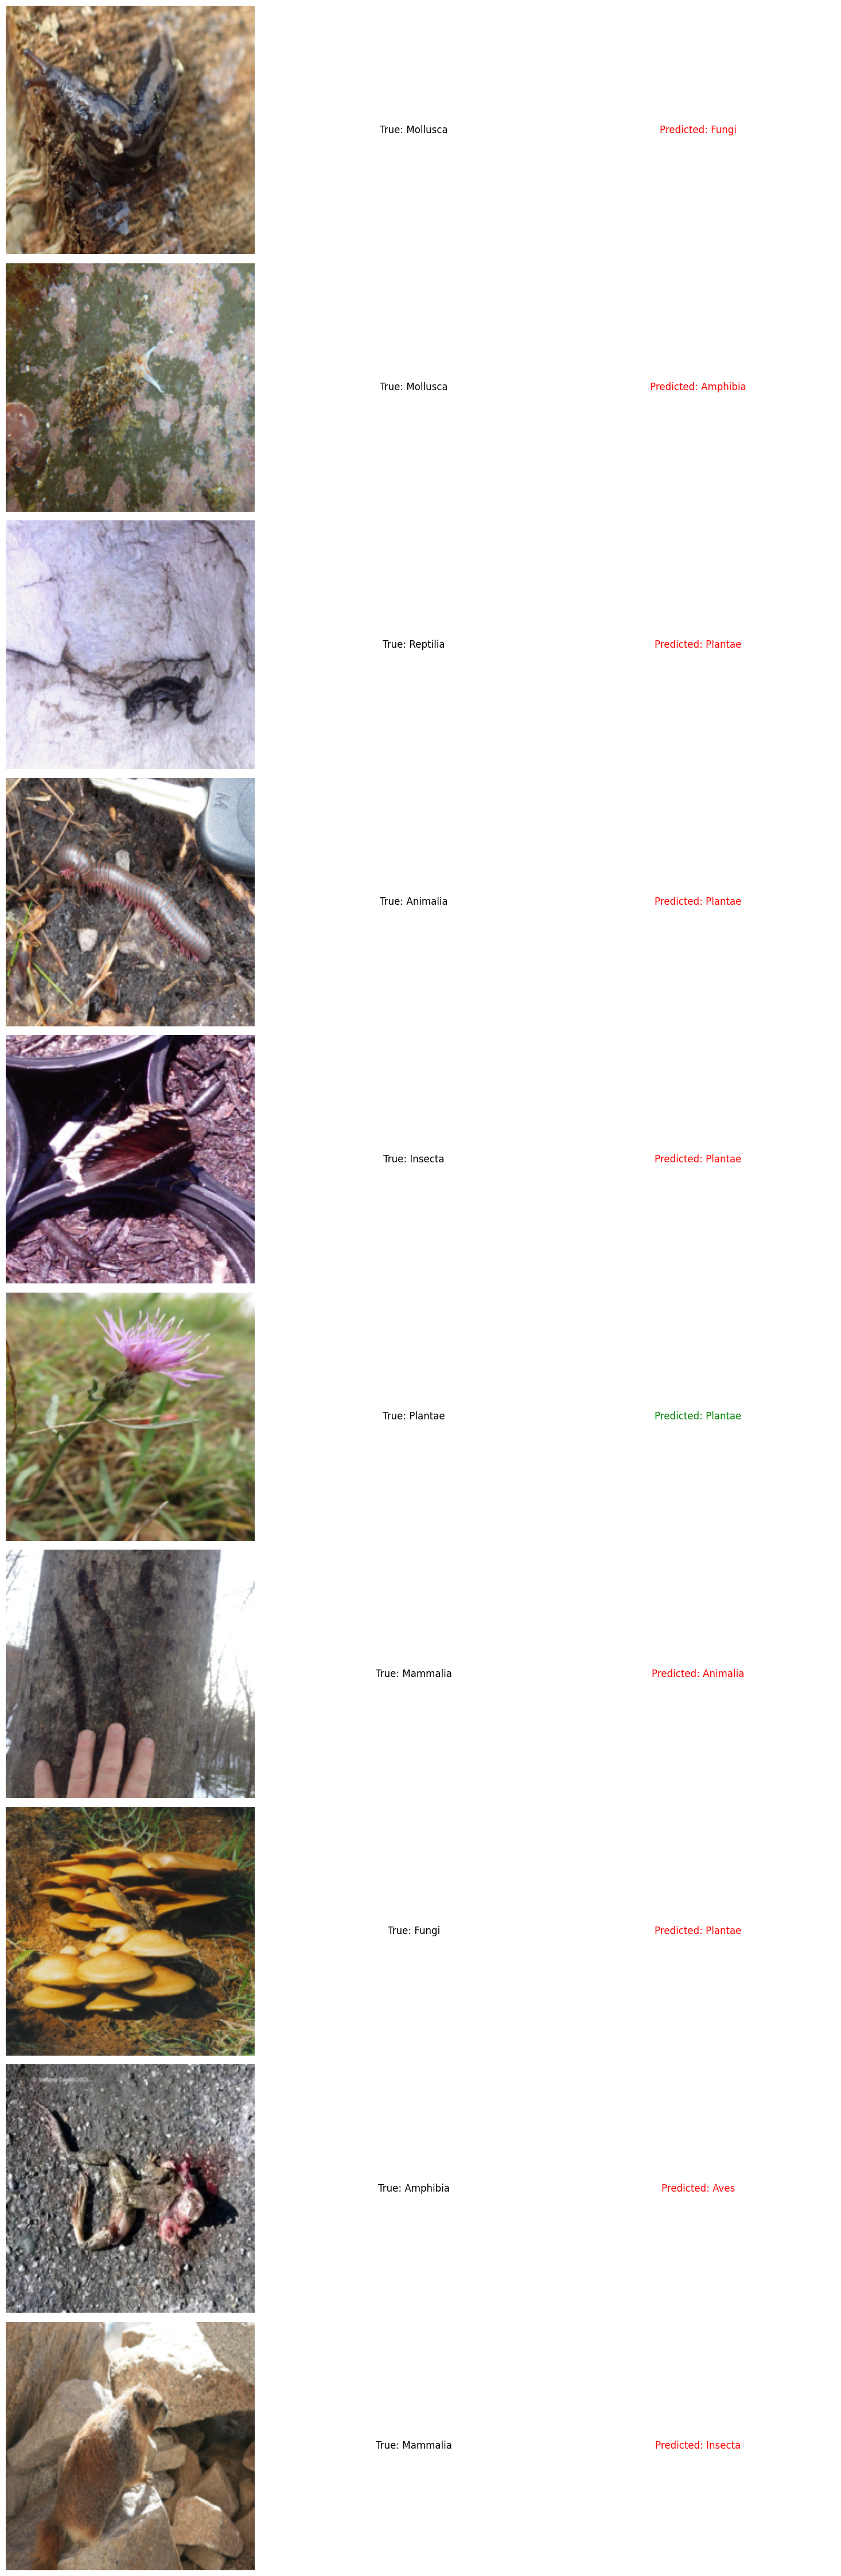

In [32]:

import matplotlib.pyplot as plt
images, labels = next(iter(test_loader))


wandb.init()

# Get a batch of test images and labels
images, labels = next(iter(test_loader))

# Load the best model weights
# model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Move to device if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images = images.to(device)
labels = labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot predictions
fig, axes = plt.subplots(10, 3, figsize=(15, 45))

for i in range(10):
    img = images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CxHxW → HxWxC
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)

    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')

    axes[i, 1].text(0.5, 0.5, f"True: {test_dataset.classes[labels[i].item()]}", 
                   ha='center', va='center', fontsize=12)
    axes[i, 1].axis('off')

    axes[i, 2].text(0.5, 0.5, f"Predicted: {test_dataset.classes[predicted[i].item()]}", 
                   ha='center', va='center', fontsize=12,
                   color='green' if predicted[i] == labels[i] else 'red')
    axes[i, 2].axis('off')

# Show the grid
plt.tight_layout()
plt.show()

wandb.log({"Test Predictions Grid": wandb.Image(fig)})
plt.close(fig)  # Close the figure to release memory

In [20]:
print(config)

{'activation': 'relu', 'batch_size': 128, 'dense_neurons': 256, 'dropout_rate': 0.2, 'epochs': 100, 'filter_size': 3, 'learning_rate': 0.00131, 'num_filters': 64, 'seed': 42, 'use_batch_norm': True}


In [ ]:
with open('/kaggle/working/best_config.json', 'r') as f:
    # config = json.load(f)
    print(config)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])
    ])
    
    # Load dataset
    test_dataset = datasets.ImageFolder(
        root='/kaggle/working/inaturalist_12K/val',
        transform=test_transform
    )
    
    # Split into train and validation
    test_size = int(len(test_dataset))
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4
    )


    

    # Initialize model
    model = FlexibleCNN(
        num_filters=config['num_filters'],
        filter_size=config['filter_size'],
        activation=config['activation'],
        dense_neurons=config['dense_neurons'],
        use_batch_norm=config['use_batch_norm'],
        dropout_rate=config['dropout_rate']
    )
    
    # Move model to GPU if available
    device = torch.device("cpu")
    model = model.to('cpu')
    # model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    model.to('cpu')
    
    # Evaluate on the test set
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy on {total} test images: {test_accuracy:.2f}%')


In [ ]:
# /kaggle/working/inaturalist_12K/train